In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [3]:
DAE_np_data_path = r'data\np\npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [4]:
np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

In [5]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section 

})
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df = df[df['E_inc'] != 2.5e8]

In [6]:
import torch
import numpy as np
import pandas as pd


def prepare_experimental_data(df):

    # incident energy 
    E_inc_unique  = sorted(df['E_inc'].unique())

    # create the grid
    E_sec_unique  = np.asarray(sorted(df['E_sec'].unique()),  dtype=float)
    theta_unique  = np.asarray(sorted(df['theta'].unique()), dtype=float)

    # create the 2D distribution
    out = []
    for E_inc in E_inc_unique:
        # Sub-select rows for this incident energy
        sub = df[df['E_inc'] == E_inc]

        # Pivot into a full 2-D grid; reindex to guarantee rectangular shape
        grid = (
            sub.pivot(index='E_sec', columns='theta', values='ddcs')
               .reindex(index=E_sec_unique, columns=theta_unique)
               .fillna(0.0)
               .to_numpy()
        )

        out.append({
            'E_inc' : torch.tensor(E_inc,        dtype=torch.float32),
            'E_sec' : torch.tensor(E_sec_unique, dtype=torch.float32),
            'theta' : torch.tensor(theta_unique, dtype=torch.float32),
            'ddcs'  : torch.tensor(grid,         dtype=torch.float32)
        })

    return out

In [7]:
out = prepare_experimental_data(df)

# same as out, but cs are integrated over theta and E_sec
# This will give us the integrated results for each incident energy
integrated_results = []

for d in out:
    E_inc = d['E_inc']
    E_sec = d['E_sec']
    theta = d['theta']
    ddcs = d['ddcs']

    int_theta = torch.trapz(ddcs, theta, dim=1)  # integrate over theta
    int_Esec = torch.trapz(ddcs, E_sec, dim=0)  # integrate over E_sec

    integrated_results.append({
        'E_inc': E_inc,
        'E_sec': E_sec,
        'theta': theta,
        'int_over_theta': int_theta,
        'int_over_E_sec': int_Esec
    })



In [8]:

def plot_integrated_cross_sections(integrated_results):
    for data in integrated_results:
        E_inc = data['E_inc'].item()  # scalar float
        E_sec = data['E_sec'].numpy()
        theta = data['theta'].numpy()
        int_over_theta = data['int_over_theta'].numpy()
        int_over_E_sec = data['int_over_E_sec'].numpy()

        # Plot integrated over theta (cross section vs E_sec)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.plot(E_sec, int_over_theta, marker='o')
        plt.xlabel('Secondary Energy $E_{sec}$')
        plt.ylabel('Integrated Cross Section (over θ)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        # Plot integrated over E_sec (cross section vs theta)
        plt.subplot(1, 2, 2)
        plt.plot(theta, int_over_E_sec, marker='o')
        plt.xlabel('Scattering Angle θ')
        plt.ylabel('Integrated Cross Section (over $E_{sec}$)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        plt.tight_layout()
        plt.show()

# plot_integrated_cross_sections(integrated_results)

In [9]:
import math
import torch
import torch.nn as nn

# ---------------------------
# Minimal NPReactionSimulator (batched only)
# ---------------------------
class NPReactionSimulator(nn.Module):
    def __init__(self, m_n=939.565, m_p=938.272, M_A=29785.0, S_n=7.70, S_p=13.46):
        super().__init__()
        self.register_buffer("m_n", torch.tensor(float(m_n)))
        self.register_buffer("m_p", torch.tensor(float(m_p)))
        self.register_buffer("M_A", torch.tensor(float(M_A)))
        self.register_buffer("S_n", torch.tensor(float(S_n)))
        self.register_buffer("S_p", torch.tensor(float(S_p)))

    def forward(self, Ek, r1, r2, r3):
        # Ek: (B,) or (B,1) -> expand to (B, N)
        if Ek.dim() == 1:
            Ek = Ek.unsqueeze(1).expand(-1, r1.shape[1])
        elif Ek.shape[1] == 1:
            Ek = Ek.expand(-1, r1.shape[1])

        m_n, m_p, M_A, S_n, S_p = (
            self.m_n.to(Ek),
            self.m_p.to(Ek),
            self.M_A.to(Ek),
            self.S_n.to(Ek),
            self.S_p.to(Ek)
        )

        denom = (M_A + m_n) ** 2
        Tk = (Ek ** 2) * m_n / (denom + 1e-12)
        Ex = Ek - Tk + S_n
        available_E = Ex - S_p
        mask = available_E > 0

        Ep_com = r1 * available_E
        E_p_com = Ep_com + m_p
        p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

        cos_theta_com = r2
        sin_theta_com = torch.sqrt(torch.clamp(1.0 - cos_theta_com**2, min=0.0))
        phi = r3

        px_com = p_mag_com * sin_theta_com * torch.cos(phi)
        py_com = p_mag_com * sin_theta_com * torch.sin(phi)
        pz_com = p_mag_com * cos_theta_com

        M_recoil = M_A + m_n
        beta = torch.clamp(Tk / (M_recoil + 1e-12), max=0.999999)
        gamma = 1.0 / torch.sqrt(torch.clamp(1.0 - beta**2, min=1e-12))

        E_lab = gamma * (E_p_com + beta * pz_com)
        pz_lab = gamma * (pz_com + beta * E_p_com)
        p_mag_lab = torch.sqrt(px_com**2 + py_com**2 + pz_lab**2 + 1e-12)

        Ep_lab = torch.where(mask, E_lab - m_p, torch.zeros_like(E_lab))
        cos_theta_lab = torch.where(mask, pz_lab / (p_mag_lab + 1e-12), torch.zeros_like(pz_lab))
        return Ep_lab, cos_theta_lab


# ---------------------------
# Minimal DifferentiableKDE (batched only)
# ---------------------------
class DifferentiableKDE(nn.Module):
    def __init__(self, x_eval, bandwidth=0.6, normalize=True):
        super().__init__()
        self.register_buffer("x_eval", x_eval.view(-1))
        self.bandwidth = float(bandwidth)
        self.normalize = bool(normalize)
        self.register_buffer("sqrt_2pi", torch.tensor(math.sqrt(2 * math.pi), dtype=torch.float32))

    def forward(self, samples, weights=None):
        # samples: (B, N)
        B, N = samples.shape
        M = self.x_eval.numel()

        if weights is None:
            weights = torch.ones_like(samples)

        x = self.x_eval.view(M, 1, 1)
        s = samples.view(1, B, N)

        diffs = (x - s) / self.bandwidth
        kernel_vals = torch.exp(-0.5 * diffs**2) / (self.bandwidth * self.sqrt_2pi)

        w = weights.view(1, B, N)
        density = (kernel_vals * w).sum(dim=2) / (w.sum(dim=2) + 1e-12)

        density = density.permute(1, 0).contiguous()  # (B, M)

        if self.normalize:
            dx = (self.x_eval[1:] - self.x_eval[:-1]).mean().clamp(min=1e-12)
            density /= (density.sum(dim=1, keepdim=True) * dx + 1e-12)

        return density  # (B, M)


# ---------------------------
# Minimal Pipeline
# ---------------------------
class ACSPipeline(nn.Module):
    def __init__(self, cos_theta_eval, kde_bandwidth=0.05):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.kde_theta = DifferentiableKDE(x_eval=cos_theta_eval, bandwidth=kde_bandwidth)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.kde_theta(cos_theta_lab, weights=valid)
    
class ECSPipeline(nn.Module):
    def __init__(self, E_eval, kde_bandwidth=0.3):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.kde_E = DifferentiableKDE(x_eval=E_eval, bandwidth=kde_bandwidth)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, _ = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.kde_E(Ep_lab, weights=valid)


In [10]:
# import torch
# import math
# import matplotlib.pyplot as plt
# import numpy as np

# # --- from your data ---
# E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
# E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
# cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Parameters
# B = len(E_inc_unique)  # one batch per experimental incoming energy
# N = 2000               # MC samples per Ek

# # Expand energies to batch
# Ek_batch = E_inc_unique.to(device)  # shape [B]

# # Random Monte Carlo parameters
# r1 = torch.rand((B, N), device=device)
# r2 = torch.rand((B, N), device=device) * 2 - 1
# r3 = torch.rand((B, N), device=device) * 2 * math.pi - math.pi

# # Create pipeline
# # pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)
# pipeline = ECSPipeline(E_eval=E_sec_exp).to(device)


# # Run simulation
# with torch.no_grad():
#     dsigma = pipeline(Ek_batch, r1, r2, r3)  # shape [B, M]

# print("dsigma shape:", dsigma.shape)

# # Plot results
# fig, axes = plt.subplots(1, B, figsize=(4 * B, 4), sharey=True)
# if B == 1:
#     axes = [axes]

# for i, ax in enumerate(axes):
#     # ax.plot(cos_theta_exp.cpu(), dsigma[i].cpu(), 'b-', lw=2)
#     ax.plot(E_sec_exp.cpu(), dsigma[i].cpu(), 'b-', lw=2)
#     # ax.set_title(f"E_k = {Ek_batch[i].item():.2f} MeV")
#     ax.set_xlabel(r"$\cos\theta$")
#     if i == 0:
#         ax.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (arb. units)")

# plt.tight_layout()
# plt.show()


In [11]:
# # TESTING 
# pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# Ek_batch = torch.tensor([70.0], device=device)  # Example single energy, shape [B]

# r1 = torch.tensor([[0.5]], device=device)
# r1 = torch.tensor([[0.5]], device=device)
# r1 = torch.tensor([[0.5]], device=device)


# # Run simulation
# with torch.no_grad():
#     dsigma = pipeline(Ek_batch, r1, r2, r3)

# dsigma

In [33]:
import torch
import torch.nn.functional as F

def kl_plus_sum_mse_loss(simulated_ddcs, experimental_ddcs, eps=1e-8, mse_weight=0.1):
    # KL (shape)
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    kl = F.kl_div(sim_dist.log(), exp_dist, reduction='batchmean', log_target=False)

    # MSE (scale)
    mse_sums = F.mse_loss(sim_sum, exp_sum)

    # Combine
    loss = kl + mse_weight * mse_sums
    return loss


def kl_mse_combined_loss(simulated_ddcs, experimental_ddcs, eps=1e-8, mse_weight=0.00001):
    """
    Combines:
      - KL divergence on normalized distributions (shape)
      - Pointwise MSE on raw values (scale & shape)

    Args:
        simulated_ddcs: (B, M) predicted differential cross section
        experimental_ddcs: (B, M) target differential cross section
        eps: small number for numerical stability
        mse_weight: relative weight of the MSE term

    Returns:
        scalar loss
    """
    # --- KL on normalized ---
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    kl = F.kl_div(sim_dist.log(), exp_dist, reduction='batchmean', log_target=False)

    # --- MSE on raw values ---
    mse_pointwise = F.mse_loss(simulated_ddcs, experimental_ddcs)

    # --- Combine ---
    loss = kl + mse_weight * mse_pointwise
    return loss

def mse_loss_log(pred, target, eps=1e-8):
    pred = torch.clamp(pred, min=eps)
    target = torch.clamp(target, min=eps)
    return torch.mean((torch.log(pred) - torch.log(target)) ** 2)


def wasserstein_1d_loss(mc_samples: torch.Tensor, exp_samples: torch.Tensor):
    """
    Compute 1D Wasserstein (Earth Mover's) distance between two sample tensors.
    Both tensors should be 1D: (batch_size,)
    """
    # Sort samples
    mc_sorted, _ = torch.sort(mc_samples)
    exp_sorted, _ = torch.sort(exp_samples)
    
    # Pad smaller tensor if needed (optional)
    n_mc = mc_sorted.shape[0]
    n_exp = exp_sorted.shape[0]
    if n_mc != n_exp:
        # Simple linear interpolation to match sizes
        exp_sorted = torch.interp(
            torch.linspace(0, 1, steps=n_mc, device=mc_samples.device),
            torch.linspace(0, 1, steps=n_exp, device=mc_samples.device),
            exp_sorted
        )
    
    # Wasserstein distance: average absolute difference
    loss = torch.mean(torch.abs(mc_sorted - exp_sorted))
    return loss



In [34]:
# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
n_lamda     = 1       # number of untrainable external parameter dependencies
n_hidden    = 24      # number of hidden neurons in the network, at each layer
n_layers    = 3       # number of hidden layers in the network
n_out       = n_in    # must match the number of output parameters
batch_size  = 64 #2_000   # samples of random number per batch, to build the distribution. Larger is better, but slower
n_mc_samples = 1024
epochs      = 1000#0   # number of epochs to train the network
lr          = 1e-3    # learning rate for the optimizer

# ------------------------------------------------------------------
# MLP producing seeds in [0,1]
# ------------------------------------------------------------------
def make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out):
    layers, d = [], n_in + n_lamda
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden), nn.ReLU()]
        d = n_hidden
    layers += [nn.Linear(d, n_out), nn.Sigmoid()]
    return nn.Sequential(*layers)

net       = make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out).to(device)
optimiser = optim.Adam(net.parameters(), lr=lr)
# ------------------------------------------------------------------

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from tqdm import trange

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------
# Prep
# -------------

# E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
# E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
# cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# ecs_pipeline = ECSPipeline(E_eval=E_sec_exp).to(device)
# acs_pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# -------------
# Training loop
# -------------

# net.train()

# all_Ek = torch.stack([res['E_inc'] for res in integrated_results]) / 1e6  # (N,)
# all_exp = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, dist_len)
# # all_exp = torch.stack([res['int_over_theta'] for res in integrated_results])  # (N, dist_len)


# all_Ek = all_Ek.to(device)
# all_exp = all_exp.to(device)

# num_samples_total = all_Ek.shape[0]

# # --- Training loop ---
# for epoch in trange(epochs, desc='Training Epochs'):
#     # Sample random indices for batch
#     # idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

#     idx = torch.zeros(batch_size, dtype=torch.long, device=device)


#     Ek_batch = all_Ek[idx]  # (B,)
#     dsigma_dOmega_exp = all_exp[idx]  # (B, M)
#     # dsigma_dE_exp = all_exp[idx]  # (B, M)


#     # Draw random uniform inputs for network
#     # Shape: (B, N, n_in)
#     uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

#     # Append Ek to each MC sample row
#     Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples).unsqueeze(-1)  # (B, N, 1)
#     net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)  # (B, N, n_in+1)

#     # Flatten for network: (B*N, n_in+1)
#     net_input_flat = net_input.reshape(-1, n_in + 1)

#     # Predict r1, r2, r3 in flat form then reshape
#     t = net(net_input_flat).reshape(batch_size, n_mc_samples, 3)
#     r1 = t[:, :, 0]
#     r2 = t[:, :, 1] * 2 - 1
#     r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

#     # Run simulation
#     dsigma_dOmega_sim = acs_pipeline(Ek_batch, r1, r2, r3)  # (B, M)
#     # dsigma_dE_sim = ecs_pipeline(Ek_batch, r1, r2, r3)  # (B, M)

#     # Compute loss
#     loss = kl_plus_sum_mse_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)
#     # loss = kl_plus_sum_mse_loss(dsigma_dE_sim, dsigma_dE_exp)

#     # loss = mse_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)

#     # loss = mse_loss_log(dsigma_dOmega_sim, dsigma_dOmega_exp)
#     # loss = mse_loss_log(dsigma_dE_sim, dsigma_dE_exp)


#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch:3d} | Loss: {loss.item():.6f}")

#-------------------------------------

# ==== Debug toggles ====
USE_FIXED_IDX = False        # True = always use the same idx for Ek
FIXED_IDX_VALUE = 0         # which dataset entry to use if above is True
USE_FIXED_MC = False         # True = use the same MC samples each epoch

# Prep experimental data
all_Ek = torch.stack([res['E_inc'] for res in integrated_results]) / 1e6  # (N,)
all_exp = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, M)

all_Ek = all_Ek.to(device)
all_exp = all_exp.to(device)
num_samples_total = all_Ek.shape[0]

# Prepare fixed MC samples if needed
if USE_FIXED_MC:
    fixed_uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

net.train()
for epoch in trange(epochs, desc='Training Epochs'):

    # ----- Index selection -----
    if USE_FIXED_IDX:
        idx = torch.full((batch_size,), FIXED_IDX_VALUE, dtype=torch.long, device=device)
    else:
        idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

    Ek_batch = all_Ek[idx]           # (B,)
    dsigma_dOmega_exp = all_exp[idx] # (B, M)

    # ----- MC samples -----
    if USE_FIXED_MC:
        uniform_samples = fixed_uniform_samples
    else:
        uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

    # Append Ek to each MC sample
    Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples).unsqueeze(-1)  # (B, N, 1)
    net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)  # (B, N, n_in+1)

    # Flatten for network
    net_input_flat = net_input.reshape(-1, n_in + 1)

    # Network forward pass
    t = net(net_input_flat).reshape(batch_size, n_mc_samples, 3)
    r1 = t[:, :, 0]
    r2 = t[:, :, 1] * 2 - 1
    r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

    # Simulation
    dsigma_dOmega_sim = acs_pipeline(Ek_batch, r1, r2, r3)  # (B, M)

    # Loss
    # loss = kl_plus_sum_mse_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)
    # loss = kl_mse_combined_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)

    loss = wasserstein_1d_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)


    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")



Training Epochs:   0%|          | 3/1000 [00:00<01:41,  9.86it/s]

Epoch   1 | Loss: 76.026184


Training Epochs:  10%|█         | 102/1000 [00:08<01:07, 13.26it/s]

Epoch 101 | Loss: 76.646225


Training Epochs:  20%|██        | 202/1000 [00:15<00:58, 13.71it/s]

Epoch 201 | Loss: 72.367409


Training Epochs:  30%|███       | 302/1000 [00:23<00:51, 13.43it/s]

Epoch 301 | Loss: 70.639099


Training Epochs:  40%|████      | 402/1000 [00:30<00:43, 13.90it/s]

Epoch 401 | Loss: 74.190910


Training Epochs:  50%|█████     | 502/1000 [00:38<00:36, 13.64it/s]

Epoch 501 | Loss: 74.416946


Training Epochs:  60%|██████    | 602/1000 [00:45<00:29, 13.52it/s]

Epoch 601 | Loss: 70.656136


Training Epochs:  70%|███████   | 702/1000 [00:53<00:22, 13.39it/s]

Epoch 701 | Loss: 70.767311


Training Epochs:  80%|████████  | 802/1000 [01:01<00:15, 12.84it/s]

Epoch 801 | Loss: 64.658775


Training Epochs:  90%|█████████ | 902/1000 [01:08<00:06, 14.14it/s]

Epoch 901 | Loss: 73.462135


Training Epochs: 100%|██████████| 1000/1000 [01:15<00:00, 13.19it/s]


In [ ]:
# import torch
# import matplotlib.pyplot as plt

# net.eval()

# n_mc_samples = 2000
# monitor_indices = [0, len(integrated_results) // 2, -1]  # pick a few energies


# for idx in monitor_indices:
#     # Experimental values
#     Ek_val = integrated_results[idx]['E_inc'] / 1e6  # scalar tensor

#     exp_dist = integrated_results[idx]['int_over_E_sec'].to(device)  # (M,)
#     # exp_dist = integrated_results[idx]['int_over_theta'].to(device)  # (M,)

#     # Shape (B=1, N) for Monte Carlo
#     Ek_batch = Ek_val.unsqueeze(0).to(device)  # (1,)
#     Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples)  # (1, N)

#     # Random latent samples: (B=1, N, n_in)
#     uniform_samples = torch.rand((1, n_mc_samples, n_in), device=device)

#     # Append Ek to each MC sample row: (1, N, n_in+1)
#     net_input = torch.cat([uniform_samples, Ek_expanded.unsqueeze(-1)], dim=-1)

#     # Flatten for net: (B*N, n_in+1)
#     net_input_flat = net_input.reshape(-1, n_in + 1)

#     with torch.no_grad():
#         t = net(net_input_flat).reshape(1, n_mc_samples, 3)
#         r1 = t[:, :, 0]
#         r2 = t[:, :, 1] * 2 - 1
#         r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

#         # Now acs_pipeline gets (B=1, N) inputs for r1, r2, r3
#         sim_dist = acs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)
#         # sim_dist = ecs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)


#     # Plot
#     plt.figure()
#     # plt.plot(cos_theta_exp.cpu(), exp_dist.cpu(), label='Experimental')
#     plt.plot(cos_theta_exp.cpu(), sim_dist.cpu(), label='Simulation')
#     plt.xlabel(r'$\cos(\theta)$')

#     # plt.plot(E_sec_exp.cpu(), exp_dist.cpu(), label='Experimental')
#     # plt.plot(E_sec_exp.cpu(), sim_dist.cpu(), label='Simulation')
#     # plt.xlabel(r'$E_{\text{sec}}$ [MeV]')
    
#     plt.ylabel(r'$d\sigma/d\Omega$')
#     plt.title(f'E_inc = {Ek_val.item():.2f} MeV')
#     plt.legend()
#     plt.show()


In [30]:
# ========= Joint, vectorized REINFORCE for ACS + ECS =========
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Beta
from tqdm import trange



# ---------------------------
# Joint pipeline (single simulator, two KDEs)
# ---------------------------
class JointACSECS(nn.Module):
    def __init__(self, cos_theta_eval, E_eval, kde_bw_theta=0.05, kde_bw_E=0.3):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.kde_theta = DifferentiableKDE(x_eval=cos_theta_eval, bandwidth=kde_bw_theta, normalize=True)
        self.kde_E     = DifferentiableKDE(x_eval=E_eval,        bandwidth=kde_bw_E,     normalize=True)

    @torch.no_grad()
    def _valid_mask(self, Ep_lab):
        return (Ep_lab > 0).float()

    def forward(self, Ek, r1, r2, r3):
        """
        Ek: (B,)                     neutron energy per example
        r1,r2,r3: (B,N)              MC randoms transformed to proper domains
        Returns:
          acs_density: (B, M_theta)
          ecs_density: (B, M_E)
        """
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)                  # (B,N) each
        valid = (Ep_lab > 0).float()
        acs_density = self.kde_theta(cos_theta_lab, weights=valid)              # (B, M_theta)
        ecs_density = self.kde_E(Ep_lab,        weights=valid)                  # (B, M_E)
        return acs_density, ecs_density


# ---------------------------
# Beta policy (vectorized)
# ---------------------------
class PolicyBeta(nn.Module):
    def __init__(self, in_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 6)  # 3 actions: (alpha,beta) each
        )

    def forward(self, x):
        # x: (B*N, in_dim)
        eps = 1e-4
        raw = F.softplus(self.net(x)) + eps
        alpha = raw[..., 0::2]  # (B*N,3)
        beta  = raw[..., 1::2]  # (B*N,3)
        return alpha, beta


# ---------------------------
# W1 on a fixed grid, per example (fully vectorized)
# ---------------------------
def wasserstein1_on_grid_rowwise(sim_density, exp_density, x_eval):
    """
    sim_density, exp_density: (B, M) normalized on same grid x_eval (M,)
    returns: (B,) W1 distances
    """
    dx = (x_eval[1] - x_eval[0]).abs().clamp_min(1e-12)
    sim_cdf = sim_density.cumsum(dim=1) * dx
    exp_cdf = exp_density.cumsum(dim=1) * dx
    w1 = torch.sum((sim_cdf - exp_cdf).abs(), dim=1) * dx
    return w1


# ---------------------------
# Setup (plugs into your existing tensors)
# ---------------------------
# You already have:
#   cos_theta_exp: (M_theta,) grid for ACS
#   E_sec_exp:     (M_E,)     grid for ECS
#   all_Ek:        (N_total,) neutron energies (float, in MeV)
#   device: your torch device
#   batch_size, n_mc_samples, epochs, USE_FIXED_IDX, FIXED_IDX_VALUE, USE_FIXED_MC, fixed_uniform_samples
#
# IMPORTANT:
#   Provide experimental densities per-batch for both ACS and ECS:
#   - acs_exp_all: (N_total, M_theta)  -> experimental dσ/dΩ on cosθ grid
#   - ecs_exp_all: (N_total, M_E)      -> experimental energy distribution on E_sec_exp grid
#
# If you only have one right now (e.g., your all_exp is ACS), create ecs_exp_all accordingly.


E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

ecs_pipeline = ECSPipeline(E_eval=E_sec_exp).to(device)
acs_pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

all_Ek = torch.stack([res['E_inc'] for res in integrated_results]) / 1e6  # (N,)
acs_exp_all = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, dist_len)
ecs_exp_all = torch.stack([res['int_over_theta'] for res in integrated_results])  # (N, dist_len)

# # ==== Debug toggles ====
USE_FIXED_IDX = False        # True = always use the same idx for Ek
FIXED_IDX_VALUE = 0         # which dataset entry to use if above is True
USE_FIXED_MC = True         # True = use the same MC samples each epoch

if USE_FIXED_MC:
    fixed_uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

joint = JointACSECS(cos_theta_eval=cos_theta_exp.to(device),
                    E_eval=E_sec_exp.to(device),
                    kde_bw_theta=0.05, kde_bw_E=0.3).to(device)

# Policy input is base_u (3) + Ek (1)
n_in = 3
in_dim = n_in + 1
policy = PolicyBeta(in_dim=in_dim, hidden=128).to(device)

# ---------------------------
# Training hyperparams
# ---------------------------
entropy_coeff     = 1e-3
baseline_momentum = 0.9
max_grad_norm     = 1.0
lr                = 2e-4
epochs            = 10000

optimiser = torch.optim.Adam(policy.parameters(), lr=lr)
baseline = torch.tensor(0.0, device=device)

# ---------------------------
# Training loop (vectorized)
# ---------------------------
for epoch in trange(epochs, desc='Training Epochs'):

    # ----- Index selection -----
    if USE_FIXED_IDX:
        idx = torch.full((batch_size,), FIXED_IDX_VALUE, dtype=torch.long, device=device)
    else:
        idx = torch.randint(0, all_Ek.shape[0], (batch_size,), device=device)  # (B,)

    Ek_batch = all_Ek[idx]  # (B,)

    # EXPERIMENTAL DENSITIES (provide these):
    # acs_exp_batch: (B, M_theta)
    # ecs_exp_batch: (B, M_E)
    acs_exp_batch = acs_exp_all[idx].to(device)   # <-- ensure you have this tensor
    ecs_exp_batch = ecs_exp_all[idx].to(device)   # <-- ensure you have this tensor

    # ----- MC base noise -----
    if USE_FIXED_MC:
        base_u = fixed_uniform_samples  # (B, N, 3) in [0,1]
    else:
        base_u = torch.rand((batch_size, n_mc_samples, n_in), device=device)

    # ----- Policy input -----
    Ek_expanded = Ek_batch[:, None, None].expand(-1, n_mc_samples, 1)  # (B,N,1)
    net_input = torch.cat([base_u, Ek_expanded], dim=-1)               # (B,N,4)
    net_input_flat = net_input.reshape(-1, in_dim)                      # (B*N, 4)

    # ----- Policy forward & sample -----
    alpha, beta = policy(net_input_flat)          # (B*N,3) each
    dist = Beta(alpha, beta)
    u = dist.sample()                             # (B*N,3)
    logp = dist.log_prob(u)                       # (B*N,3)

    # Map to simulator domains (vectorized)
    u_bN3 = u.view(batch_size, n_mc_samples, 3)   # (B,N,3)
    r1 = u_bN3[..., 0]                            # (B,N) in [0,1]
    r2 = 2.0 * u_bN3[..., 1] - 1.0               # (B,N) in [-1,1]
    r3 = (2.0 * torch.pi) * u_bN3[..., 2] - torch.pi  # (B,N) in [-π,π]

    # ----- Single simulator call → both densities -----
    acs_sim, ecs_sim = joint(Ek_batch, r1, r2, r3)  # (B,M_theta), (B,M_E)

    # ----- Per-example rewards (negative W1) -----
    w1_theta  = wasserstein1_on_grid_rowwise(acs_sim, acs_exp_batch, cos_theta_exp.to(device))  # (B,)
    w1_energy = wasserstein1_on_grid_rowwise(ecs_sim, ecs_exp_batch, E_sec_exp.to(device))      # (B,)
    # Combine: weights if needed, here equal
    reward = -(w1_theta + w1_energy)  # (B,)

    # ----- Variance reduction: moving baseline + norm -----
    with torch.no_grad():
        baseline = baseline_momentum * baseline + (1.0 - baseline_momentum) * reward.mean()
        advantage = reward - baseline
        adv_std = advantage.std().clamp_min(1e-6)
        advantage = advantage / adv_std

    # ----- Entropy bonus -----
    entropy = dist.entropy().view(batch_size, n_mc_samples, 3).sum(dim=(1,2))  # (B,)

    # ----- Sum log-probs over all actions per example -----
    logp_sum = logp.view(batch_size, n_mc_samples, 3).sum(dim=(1,2))           # (B,)

    # ----- REINFORCE objective -----
    loss = -(advantage.detach() * logp_sum + entropy_coeff * entropy).mean()

    optimiser.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | W1_theta: {w1_theta.mean().item():.6f} | "
              f"W1_energy: {w1_energy.mean().item():.6f} | "
              f"Reward: {reward.mean().item():.6f} | Loss: {loss.item():.6f}")


Training Epochs:   0%|          | 12/10000 [00:00<02:55, 56.95it/s]

Epoch    0 | W1_theta: 0.064420 | W1_energy: 42.899567 | Reward: -42.963989 | Loss: 2163.740723


Training Epochs:   1%|          | 115/10000 [00:01<02:06, 78.37it/s]

Epoch  100 | W1_theta: 0.052618 | W1_energy: 31.562222 | Reward: -31.614840 | Loss: -7.840487


Training Epochs:   2%|▏         | 216/10000 [00:02<01:56, 83.76it/s]

Epoch  200 | W1_theta: 0.082304 | W1_energy: 16.617533 | Reward: -16.699839 | Loss: -57.844822


Training Epochs:   3%|▎         | 311/10000 [00:03<01:49, 88.56it/s]

Epoch  300 | W1_theta: 0.055717 | W1_energy: 16.019993 | Reward: -16.075706 | Loss: -80.168594


Training Epochs:   4%|▍         | 413/10000 [00:04<01:39, 95.92it/s]

Epoch  400 | W1_theta: 0.048507 | W1_energy: 26.007635 | Reward: -26.056141 | Loss: 11.907732


Training Epochs:   5%|▌         | 513/10000 [00:05<01:41, 93.13it/s]

Epoch  500 | W1_theta: 0.052549 | W1_energy: 22.229643 | Reward: -22.282190 | Loss: -33.345028


Training Epochs:   6%|▌         | 614/10000 [00:07<01:47, 87.08it/s]

Epoch  600 | W1_theta: 0.077346 | W1_energy: 14.468828 | Reward: -14.546174 | Loss: -167.262161


Training Epochs:   7%|▋         | 716/10000 [00:08<01:44, 88.82it/s]

Epoch  700 | W1_theta: 0.054513 | W1_energy: 24.002668 | Reward: -24.057182 | Loss: -296.697601


Training Epochs:   8%|▊         | 811/10000 [00:09<01:39, 92.51it/s]

Epoch  800 | W1_theta: 0.104707 | W1_energy: 19.209021 | Reward: -19.313728 | Loss: -0.831421


Training Epochs:   9%|▉         | 911/10000 [00:10<01:36, 94.10it/s]

Epoch  900 | W1_theta: 0.108579 | W1_energy: 11.292007 | Reward: -11.400586 | Loss: -120.855148


Training Epochs:  10%|█         | 1011/10000 [00:11<01:40, 89.46it/s]

Epoch 1000 | W1_theta: 0.117531 | W1_energy: 11.502066 | Reward: -11.619596 | Loss: -88.363373


Training Epochs:  11%|█         | 1115/10000 [00:12<01:42, 86.58it/s]

Epoch 1100 | W1_theta: 0.096554 | W1_energy: 25.021328 | Reward: -25.117884 | Loss: 54.291336


Training Epochs:  12%|█▏        | 1215/10000 [00:13<01:40, 87.77it/s]

Epoch 1200 | W1_theta: 0.120816 | W1_energy: 9.127022 | Reward: -9.247837 | Loss: -155.135605


Training Epochs:  13%|█▎        | 1312/10000 [00:14<01:50, 78.73it/s]

Epoch 1300 | W1_theta: 0.109002 | W1_energy: 22.226664 | Reward: -22.335667 | Loss: 13.063576


Training Epochs:  14%|█▍        | 1417/10000 [00:16<01:40, 85.20it/s]

Epoch 1400 | W1_theta: 0.078352 | W1_energy: 40.335621 | Reward: -40.413975 | Loss: 128.947113


Training Epochs:  15%|█▌        | 1514/10000 [00:17<01:42, 82.49it/s]

Epoch 1500 | W1_theta: 0.050174 | W1_energy: 16.777161 | Reward: -16.827335 | Loss: -46.241997


Training Epochs:  16%|█▌        | 1615/10000 [00:18<01:46, 78.48it/s]

Epoch 1600 | W1_theta: 0.065757 | W1_energy: 14.535664 | Reward: -14.601423 | Loss: -71.391724


Training Epochs:  17%|█▋        | 1711/10000 [00:19<01:40, 82.12it/s]

Epoch 1700 | W1_theta: 0.050633 | W1_energy: 18.544399 | Reward: -18.595036 | Loss: -65.375397


Training Epochs:  18%|█▊        | 1810/10000 [00:21<01:35, 85.71it/s]

Epoch 1800 | W1_theta: 0.050327 | W1_energy: 24.519510 | Reward: -24.569838 | Loss: 26.499210


Training Epochs:  19%|█▉        | 1918/10000 [00:22<01:27, 91.98it/s]

Epoch 1900 | W1_theta: 0.058016 | W1_energy: 19.665947 | Reward: -19.723961 | Loss: -19.897549


Training Epochs:  20%|██        | 2020/10000 [00:23<01:23, 95.17it/s]

Epoch 2000 | W1_theta: 0.056715 | W1_energy: 13.804113 | Reward: -13.860829 | Loss: -54.663696


Training Epochs:  21%|██        | 2118/10000 [00:24<01:33, 84.35it/s]

Epoch 2100 | W1_theta: 0.046496 | W1_energy: 17.296127 | Reward: -17.342623 | Loss: 2.001415


Training Epochs:  22%|██▏       | 2213/10000 [00:25<01:28, 88.42it/s]

Epoch 2200 | W1_theta: 0.066148 | W1_energy: 13.403337 | Reward: -13.469485 | Loss: -118.870636


Training Epochs:  23%|██▎       | 2316/10000 [00:26<01:30, 85.19it/s]

Epoch 2300 | W1_theta: 0.067042 | W1_energy: 11.741635 | Reward: -11.808677 | Loss: -121.857498


Training Epochs:  24%|██▍       | 2415/10000 [00:28<01:34, 79.87it/s]

Epoch 2400 | W1_theta: 0.053667 | W1_energy: 25.328291 | Reward: -25.381958 | Loss: 37.541573


Training Epochs:  25%|██▌       | 2515/10000 [00:29<01:18, 95.33it/s]

Epoch 2500 | W1_theta: 0.046367 | W1_energy: 42.314323 | Reward: -42.360691 | Loss: 114.280182


Training Epochs:  26%|██▌       | 2615/10000 [00:30<01:17, 95.89it/s]

Epoch 2600 | W1_theta: 0.080877 | W1_energy: 24.961100 | Reward: -25.041975 | Loss: -103.001945


Training Epochs:  27%|██▋       | 2717/10000 [00:31<01:19, 91.65it/s]

Epoch 2700 | W1_theta: 0.116109 | W1_energy: 15.296862 | Reward: -15.412971 | Loss: -151.734085


Training Epochs:  28%|██▊       | 2816/10000 [00:32<01:19, 90.71it/s]

Epoch 2800 | W1_theta: 0.104591 | W1_energy: 26.207104 | Reward: -26.311693 | Loss: 0.830969


Training Epochs:  29%|██▉       | 2912/10000 [00:33<01:26, 81.70it/s]

Epoch 2900 | W1_theta: 0.105811 | W1_energy: 26.360769 | Reward: -26.466581 | Loss: -22.177263


Training Epochs:  30%|███       | 3012/10000 [00:34<01:17, 90.70it/s]

Epoch 3000 | W1_theta: 0.110370 | W1_energy: 19.971128 | Reward: -20.081499 | Loss: -46.410992


Training Epochs:  31%|███       | 3110/10000 [00:35<01:17, 88.69it/s]

Epoch 3100 | W1_theta: 0.119390 | W1_energy: 13.821362 | Reward: -13.940752 | Loss: -95.485184


Training Epochs:  32%|███▏      | 3208/10000 [00:37<01:24, 80.83it/s]

Epoch 3200 | W1_theta: 0.101781 | W1_energy: 23.822577 | Reward: -23.924356 | Loss: 47.077034


Training Epochs:  33%|███▎      | 3316/10000 [00:38<01:17, 85.90it/s]

Epoch 3300 | W1_theta: 0.107744 | W1_energy: 16.280323 | Reward: -16.388067 | Loss: -51.260296


Training Epochs:  34%|███▍      | 3416/10000 [00:39<01:16, 85.91it/s]

Epoch 3400 | W1_theta: 0.126094 | W1_energy: 8.953636 | Reward: -9.079729 | Loss: -161.165329


Training Epochs:  35%|███▌      | 3520/10000 [00:40<01:10, 91.63it/s]

Epoch 3500 | W1_theta: 0.091895 | W1_energy: 27.674580 | Reward: -27.766476 | Loss: 49.096016


Training Epochs:  36%|███▌      | 3618/10000 [00:41<01:12, 87.73it/s]

Epoch 3600 | W1_theta: 0.101205 | W1_energy: 22.490974 | Reward: -22.592178 | Loss: 51.609489


Training Epochs:  37%|███▋      | 3720/10000 [00:42<01:11, 87.52it/s]

Epoch 3700 | W1_theta: 0.096719 | W1_energy: 25.077887 | Reward: -25.174606 | Loss: 26.258821


Training Epochs:  38%|███▊      | 3819/10000 [00:44<01:11, 85.99it/s]

Epoch 3800 | W1_theta: 0.104004 | W1_energy: 24.146614 | Reward: -24.250618 | Loss: 62.319298


Training Epochs:  39%|███▉      | 3919/10000 [00:45<01:05, 92.55it/s]

Epoch 3900 | W1_theta: 0.113163 | W1_energy: 13.645301 | Reward: -13.758463 | Loss: -74.764694


Training Epochs:  40%|████      | 4009/10000 [00:46<01:06, 90.16it/s]

Epoch 4000 | W1_theta: 0.106060 | W1_energy: 19.053839 | Reward: -19.159899 | Loss: -23.303944


Training Epochs:  41%|████      | 4111/10000 [00:47<01:07, 86.78it/s]

Epoch 4100 | W1_theta: 0.092756 | W1_energy: 26.331264 | Reward: -26.424019 | Loss: 78.549553


Training Epochs:  42%|████▏     | 4213/10000 [00:48<01:03, 91.56it/s]

Epoch 4200 | W1_theta: 0.113308 | W1_energy: 13.248065 | Reward: -13.361374 | Loss: -61.992561


Training Epochs:  43%|████▎     | 4311/10000 [00:49<01:04, 88.12it/s]

Epoch 4300 | W1_theta: 0.116731 | W1_energy: 13.321120 | Reward: -13.437852 | Loss: -92.958916


Training Epochs:  44%|████▍     | 4410/10000 [00:50<01:05, 85.72it/s]

Epoch 4400 | W1_theta: 0.125420 | W1_energy: 7.589527 | Reward: -7.714948 | Loss: -176.807495


Training Epochs:  45%|████▌     | 4512/10000 [00:52<01:02, 87.81it/s]

Epoch 4500 | W1_theta: 0.109502 | W1_energy: 22.077816 | Reward: -22.187317 | Loss: -9.205275


Training Epochs:  46%|████▌     | 4618/10000 [00:53<00:55, 96.44it/s]

Epoch 4600 | W1_theta: 0.111377 | W1_energy: 19.305777 | Reward: -19.417154 | Loss: -76.684296


Training Epochs:  47%|████▋     | 4719/10000 [00:54<00:58, 91.01it/s]

Epoch 4700 | W1_theta: 0.119818 | W1_energy: 15.321097 | Reward: -15.440916 | Loss: -85.163406


Training Epochs:  48%|████▊     | 4817/10000 [00:55<00:58, 88.61it/s]

Epoch 4800 | W1_theta: 0.117005 | W1_energy: 17.075441 | Reward: -17.192446 | Loss: -75.395477


Training Epochs:  49%|████▉     | 4916/10000 [00:56<00:54, 93.45it/s]

Epoch 4900 | W1_theta: 0.109831 | W1_energy: 18.754768 | Reward: -18.864599 | Loss: -48.720428


Training Epochs:  50%|█████     | 5016/10000 [00:57<00:53, 93.11it/s]

Epoch 5000 | W1_theta: 0.113162 | W1_energy: 17.239614 | Reward: -17.352776 | Loss: -49.959404


Training Epochs:  51%|█████     | 5117/10000 [00:58<00:51, 94.69it/s]

Epoch 5100 | W1_theta: 0.117263 | W1_energy: 16.529865 | Reward: -16.647127 | Loss: -46.959579


Training Epochs:  52%|█████▏    | 5218/10000 [00:59<00:49, 96.98it/s]

Epoch 5200 | W1_theta: 0.100180 | W1_energy: 28.055849 | Reward: -28.156031 | Loss: 7.807235


Training Epochs:  53%|█████▎    | 5310/10000 [01:00<00:48, 96.17it/s]

Epoch 5300 | W1_theta: 0.116880 | W1_energy: 16.080183 | Reward: -16.197065 | Loss: -56.079727


Training Epochs:  54%|█████▍    | 5411/10000 [01:01<00:52, 88.24it/s]

Epoch 5400 | W1_theta: 0.099966 | W1_energy: 12.230521 | Reward: -12.330488 | Loss: -94.950600


Training Epochs:  55%|█████▌    | 5508/10000 [01:03<00:58, 76.14it/s]

Epoch 5500 | W1_theta: 0.074464 | W1_energy: 10.171011 | Reward: -10.245475 | Loss: -150.193481


Training Epochs:  56%|█████▌    | 5617/10000 [01:04<00:51, 84.40it/s]

Epoch 5600 | W1_theta: 0.126621 | W1_energy: 10.599701 | Reward: -10.726323 | Loss: -174.653488


Training Epochs:  57%|█████▋    | 5715/10000 [01:05<00:45, 95.03it/s]

Epoch 5700 | W1_theta: 0.083781 | W1_energy: 25.790205 | Reward: -25.873987 | Loss: 0.641933


Training Epochs:  58%|█████▊    | 5815/10000 [01:06<00:44, 94.11it/s]

Epoch 5800 | W1_theta: 0.122678 | W1_energy: 12.305887 | Reward: -12.428564 | Loss: -148.078461


Training Epochs:  59%|█████▉    | 5920/10000 [01:07<00:44, 91.82it/s]

Epoch 5900 | W1_theta: 0.127615 | W1_energy: 13.338947 | Reward: -13.466563 | Loss: -158.862015


Training Epochs:  60%|██████    | 6011/10000 [01:08<00:42, 93.83it/s]

Epoch 6000 | W1_theta: 0.112667 | W1_energy: 16.979013 | Reward: -17.091681 | Loss: -85.744392


Training Epochs:  61%|██████    | 6114/10000 [01:09<00:39, 97.56it/s]

Epoch 6100 | W1_theta: 0.090168 | W1_energy: 30.968813 | Reward: -31.058983 | Loss: 65.767746


Training Epochs:  62%|██████▏   | 6216/10000 [01:11<00:40, 94.04it/s]

Epoch 6200 | W1_theta: 0.106574 | W1_energy: 25.768770 | Reward: -25.875343 | Loss: 40.926079


Training Epochs:  63%|██████▎   | 6316/10000 [01:12<00:40, 91.16it/s]

Epoch 6300 | W1_theta: 0.115636 | W1_energy: 22.753345 | Reward: -22.868982 | Loss: 4.726067


Training Epochs:  64%|██████▍   | 6417/10000 [01:13<00:36, 98.28it/s]

Epoch 6400 | W1_theta: 0.115800 | W1_energy: 24.913427 | Reward: -25.029228 | Loss: -11.868069


Training Epochs:  65%|██████▌   | 6515/10000 [01:14<00:37, 92.72it/s]

Epoch 6500 | W1_theta: 0.103867 | W1_energy: 29.530195 | Reward: -29.634062 | Loss: 5.519699


Training Epochs:  66%|██████▌   | 6615/10000 [01:15<00:36, 93.72it/s]

Epoch 6600 | W1_theta: 0.111080 | W1_energy: 24.019512 | Reward: -24.130594 | Loss: -11.256755


Training Epochs:  67%|██████▋   | 6713/10000 [01:16<00:42, 77.88it/s]

Epoch 6700 | W1_theta: 0.097243 | W1_energy: 28.749687 | Reward: -28.846931 | Loss: 11.016562


Training Epochs:  68%|██████▊   | 6813/10000 [01:17<00:35, 89.52it/s]

Epoch 6800 | W1_theta: 0.109444 | W1_energy: 20.966322 | Reward: -21.075766 | Loss: -26.486242


Training Epochs:  69%|██████▉   | 6918/10000 [01:19<00:36, 85.02it/s]

Epoch 6900 | W1_theta: 0.121602 | W1_energy: 15.475512 | Reward: -15.597113 | Loss: -95.729004


Training Epochs:  70%|███████   | 7013/10000 [01:20<00:34, 86.97it/s]

Epoch 7000 | W1_theta: 0.120379 | W1_energy: 17.150928 | Reward: -17.271309 | Loss: -101.097778


Training Epochs:  71%|███████   | 7115/10000 [01:21<00:34, 84.13it/s]

Epoch 7100 | W1_theta: 0.103783 | W1_energy: 30.520849 | Reward: -30.624630 | Loss: 39.802155


Training Epochs:  72%|███████▏  | 7219/10000 [01:22<00:31, 88.79it/s]

Epoch 7200 | W1_theta: 0.109518 | W1_energy: 26.627302 | Reward: -26.736818 | Loss: 6.030251


Training Epochs:  73%|███████▎  | 7313/10000 [01:23<00:30, 88.24it/s]

Epoch 7300 | W1_theta: 0.112836 | W1_energy: 24.618195 | Reward: -24.731030 | Loss: -55.068817


Training Epochs:  74%|███████▍  | 7414/10000 [01:24<00:31, 81.75it/s]

Epoch 7400 | W1_theta: 0.121899 | W1_energy: 16.753265 | Reward: -16.875166 | Loss: -143.009644


Training Epochs:  75%|███████▌  | 7515/10000 [01:26<00:29, 83.36it/s]

Epoch 7500 | W1_theta: 0.119445 | W1_energy: 12.735312 | Reward: -12.854755 | Loss: -125.972839


Training Epochs:  76%|███████▌  | 7613/10000 [01:27<00:29, 80.91it/s]

Epoch 7600 | W1_theta: 0.110005 | W1_energy: 15.430962 | Reward: -15.540966 | Loss: -17.079983


Training Epochs:  77%|███████▋  | 7713/10000 [01:28<00:27, 83.43it/s]

Epoch 7700 | W1_theta: 0.107962 | W1_energy: 17.702482 | Reward: -17.810444 | Loss: -7.166037


Training Epochs:  78%|███████▊  | 7811/10000 [01:29<00:27, 79.56it/s]

Epoch 7800 | W1_theta: 0.104049 | W1_energy: 22.772476 | Reward: -22.876524 | Loss: 41.115372


Training Epochs:  79%|███████▉  | 7912/10000 [01:31<00:27, 76.91it/s]

Epoch 7900 | W1_theta: 0.115526 | W1_energy: 13.558218 | Reward: -13.673744 | Loss: -73.973396


Training Epochs:  80%|████████  | 8013/10000 [01:32<00:23, 86.11it/s]

Epoch 8000 | W1_theta: 0.119038 | W1_energy: 13.250183 | Reward: -13.369220 | Loss: -109.835426


Training Epochs:  81%|████████  | 8113/10000 [01:33<00:23, 79.96it/s]

Epoch 8100 | W1_theta: 0.095847 | W1_energy: 26.451584 | Reward: -26.547430 | Loss: 75.705544


Training Epochs:  82%|████████▏ | 8211/10000 [01:34<00:21, 81.45it/s]

Epoch 8200 | W1_theta: 0.105125 | W1_energy: 20.235516 | Reward: -20.340643 | Loss: 94.943985


Training Epochs:  83%|████████▎ | 8311/10000 [01:36<00:20, 84.31it/s]

Epoch 8300 | W1_theta: 0.108370 | W1_energy: 20.168959 | Reward: -20.277327 | Loss: 17.283936


Training Epochs:  84%|████████▍ | 8412/10000 [01:37<00:19, 81.62it/s]

Epoch 8400 | W1_theta: 0.113063 | W1_energy: 12.742699 | Reward: -12.855761 | Loss: -107.738846


Training Epochs:  85%|████████▌ | 8511/10000 [01:38<00:17, 83.97it/s]

Epoch 8500 | W1_theta: 0.119456 | W1_energy: 12.129344 | Reward: -12.248800 | Loss: -80.310028


Training Epochs:  86%|████████▌ | 8610/10000 [01:39<00:17, 81.36it/s]

Epoch 8600 | W1_theta: 0.117204 | W1_energy: 13.172285 | Reward: -13.289488 | Loss: -59.316998


Training Epochs:  87%|████████▋ | 8719/10000 [01:41<00:14, 85.86it/s]

Epoch 8700 | W1_theta: 0.099194 | W1_energy: 24.265505 | Reward: -24.364698 | Loss: 36.446079


Training Epochs:  88%|████████▊ | 8810/10000 [01:42<00:14, 80.46it/s]

Epoch 8800 | W1_theta: 0.112831 | W1_energy: 13.292560 | Reward: -13.405390 | Loss: -66.210312


Training Epochs:  89%|████████▉ | 8918/10000 [01:43<00:11, 96.57it/s]

Epoch 8900 | W1_theta: 0.115130 | W1_energy: 12.202746 | Reward: -12.317877 | Loss: -52.315224


Training Epochs:  90%|█████████ | 9021/10000 [01:44<00:10, 93.24it/s]

Epoch 9000 | W1_theta: 0.125152 | W1_energy: 7.016045 | Reward: -7.141197 | Loss: -254.319778


Training Epochs:  91%|█████████ | 9113/10000 [01:45<00:09, 97.93it/s]

Epoch 9100 | W1_theta: 0.124205 | W1_energy: 8.827381 | Reward: -8.951588 | Loss: -134.474609


Training Epochs:  92%|█████████▏| 9218/10000 [01:46<00:08, 92.07it/s]

Epoch 9200 | W1_theta: 0.116681 | W1_energy: 13.856329 | Reward: -13.973011 | Loss: -38.600243


Training Epochs:  93%|█████████▎| 9314/10000 [01:47<00:08, 85.19it/s]

Epoch 9300 | W1_theta: 0.114282 | W1_energy: 14.914120 | Reward: -15.028400 | Loss: -19.523434


Training Epochs:  94%|█████████▍| 9410/10000 [01:49<00:07, 80.47it/s]

Epoch 9400 | W1_theta: 0.131598 | W1_energy: 4.257778 | Reward: -4.389376 | Loss: -343.580902


Training Epochs:  95%|█████████▌| 9513/10000 [01:50<00:05, 96.65it/s]

Epoch 9500 | W1_theta: 0.103388 | W1_energy: 19.118256 | Reward: -19.221643 | Loss: 27.777081


Training Epochs:  96%|█████████▌| 9618/10000 [01:51<00:03, 98.90it/s]

Epoch 9600 | W1_theta: 0.109700 | W1_energy: 13.447245 | Reward: -13.556943 | Loss: -8.198025


Training Epochs:  97%|█████████▋| 9712/10000 [01:52<00:02, 100.61it/s]

Epoch 9700 | W1_theta: 0.112010 | W1_energy: 13.714809 | Reward: -13.826821 | Loss: -90.552536


Training Epochs:  98%|█████████▊| 9812/10000 [01:53<00:02, 88.02it/s] 

Epoch 9800 | W1_theta: 0.125269 | W1_energy: 8.355207 | Reward: -8.480476 | Loss: -229.450027


Training Epochs:  99%|█████████▉| 9915/10000 [01:54<00:00, 99.42it/s]

Epoch 9900 | W1_theta: 0.121214 | W1_energy: 8.602933 | Reward: -8.724146 | Loss: -288.745941


Training Epochs: 100%|██████████| 10000/10000 [01:55<00:00, 86.67it/s]


In [20]:
all_Ek

tensor([ 65.,  75.,  85.,  95., 110., 130., 150., 170., 190., 210., 230.])

In [31]:
import matplotlib.pyplot as plt

acs_exp_all = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, dist_len)
ecs_exp_all = torch.stack([res['int_over_theta'] for res in integrated_results])  # (N, dist_len)

def plot_results_for_all_Ek(n_mc_samples=512):
    """
    Plots ACS and ECS for every incident neutron energy in all_Ek.
    Uses trained net + pipelines.
    """
    fig, axes = plt.subplots(len(all_Ek), 2, figsize=(10, 4 * len(all_Ek)))

    for row_idx, Ek_val in enumerate(all_Ek):
        Ek_batch = Ek_val.unsqueeze(0)  # shape (1,)
        
        # Prepare MC samples
        uniform_samples = torch.rand((1, n_mc_samples, n_in), device=device)
        Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples).unsqueeze(-1)
        net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)
        net_input_flat = net_input.reshape(-1, n_in + 1)

        # NN forward -> transformed MC variables
        net_out = net(net_input_flat)
        if isinstance(net_out, tuple):
            net_out = net_out[0]  # take first element if tuple

        t = net_out.reshape(1, n_mc_samples, 3)
        r1 = t[:, :, 0]
        r2 = t[:, :, 1] * 2 - 1
        r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

        # ACS simulation + exp
        acs_sim = acs_pipeline(Ek_batch, r1, r2, r3).detach().cpu().numpy()[0]
        acs_exp = acs_exp_all[row_idx].detach().cpu().numpy()

        # ECS simulation + exp
        ecs_sim = ecs_pipeline(Ek_batch, r1, r2, r3).detach().cpu().numpy()[0]
        ecs_exp = ecs_exp_all[row_idx].detach().cpu().numpy()

        cos_theta_vals = acs_pipeline.kde_theta.x_eval.cpu().numpy()
        E_vals = ecs_pipeline.kde_E.x_eval.cpu().numpy()

        # Plot ACS
        axes[row_idx, 0].plot(cos_theta_vals, acs_exp, label="Experimental")
        axes[row_idx, 0].plot(cos_theta_vals, acs_sim, label="Simulated")
        axes[row_idx, 0].set_title(f"ACS @ {Ek_val.item():.3f} MeV")
        axes[row_idx, 0].set_xlabel("cos(theta)")
        axes[row_idx, 0].set_ylabel("dσ/dΩ")
        axes[row_idx, 0].legend()

        # Plot ECS
        axes[row_idx, 1].plot(E_vals, ecs_exp, label="Experimental")
        axes[row_idx, 1].plot(E_vals, ecs_sim, label="Simulated")
        axes[row_idx, 1].set_title(f"ECS @ {Ek_val.item():.3f} MeV")
        axes[row_idx, 1].set_xlabel("Proton Energy (MeV)")
        axes[row_idx, 1].set_ylabel("dσ/dE")
        axes[row_idx, 1].legend()

    plt.tight_layout()
    plt.show()


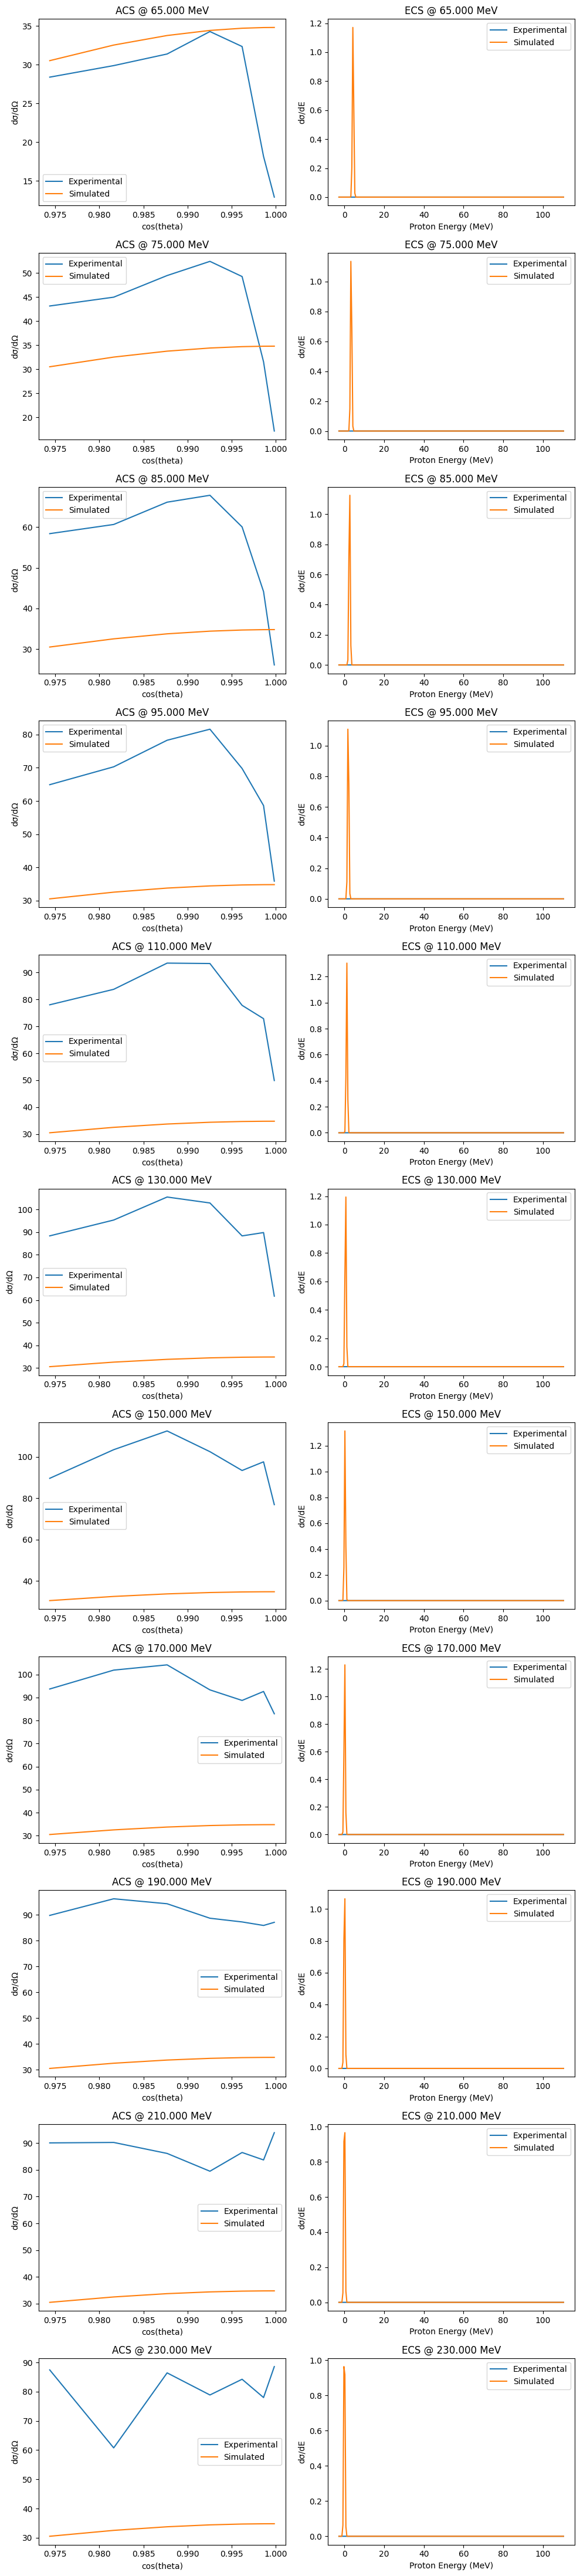

In [32]:
plot_results_for_all_Ek(n_mc_samples=1024)
